loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
142


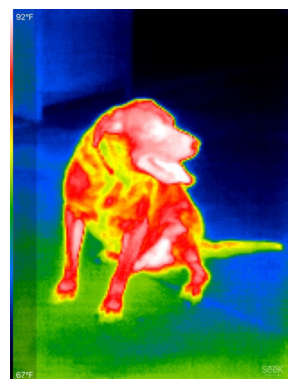

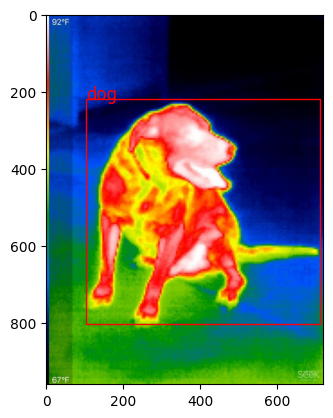

In [7]:
import os
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data_dir = '/home/hgq/Projects/DLF/dog'
splits = ['train', 'valid', 'test']

for split in splits:
    image_dir = os.path.join(data_dir, split)
    ann_file = os.path.join(image_dir, '_annotations.coco.json')

    coco = COCO(ann_file)

    img_ids = coco.getImgIds()
    print(len(img_ids))

    img_info = coco.loadImgs(img_ids[0])[0] 
    image_path = os.path.join(image_dir, img_info['file_name'])
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(ann_ids)

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for ann in annotations:
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1], category_name, color='red', fontsize=12)

    plt.show()

    break


In [8]:
import torch
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import copy

train_ann = "/home/hgq/Projects/DLF/dog/train/_annotations.coco.json"
valid_dir = "/path/to/valid/images"
valid_ann = "/home/hgq/Projects/DLF/dog/valid/_annotations.coco.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

train_dir = '/home/hgq/Projects/DLF/dog/train'
dataset = CustomDataset(train_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
total_images_count = 0

for images in loader:
    batch_images_count = images.size(0)
    images = images.view(batch_images_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_images_count

mean /= total_images_count
std /= total_images_count

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([0.2885, 0.3756, 0.3216])
Standard Deviation: tensor([0.3790, 0.2832, 0.2951])


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Training with lr=0.01, optimizer=Adam, regularization=L2, weight_decay=0.0
Epoch [1/50], Train Loss: 1.6993, Valid Loss: 33233.1523, Train Acc: 0.3282, Valid Acc: 0.5000
Epoch [2/50], Train Loss: 0.8960, Valid Loss: 2813.3208, Train Acc: 0.5115, Valid Acc: 0.5000
Epoch [3/50], Train Loss: 0.9648, Valid Loss: 827.0377, Train Acc: 0.4885, Valid Acc: 0.5000
Epoch [4/50], Train Loss: 1.1949, Valid Loss: 35.0106, Train Acc: 0.4809, Valid Acc: 0.5000
Epoch [5/50], Train Loss: 0.6929, Valid Loss: 0.9230, Train Acc: 0.6031, Valid Acc: 0.5000
Epoch [6/50], Train Loss: 0.6007, Valid Loss: 0.9575, Train Acc: 0.6336, Valid Acc: 0.4722
Epoch [7/50], Train Loss: 0.6202, Valid Loss: 1.2376, Train Acc: 0.6336, Valid Acc: 0.7222
Epoch [8/50], Train Loss: 1.1018, Valid Loss: 0.9205, Train Acc: 0.6718, Valid Acc: 0.5833
Epoch [9/50], Train L

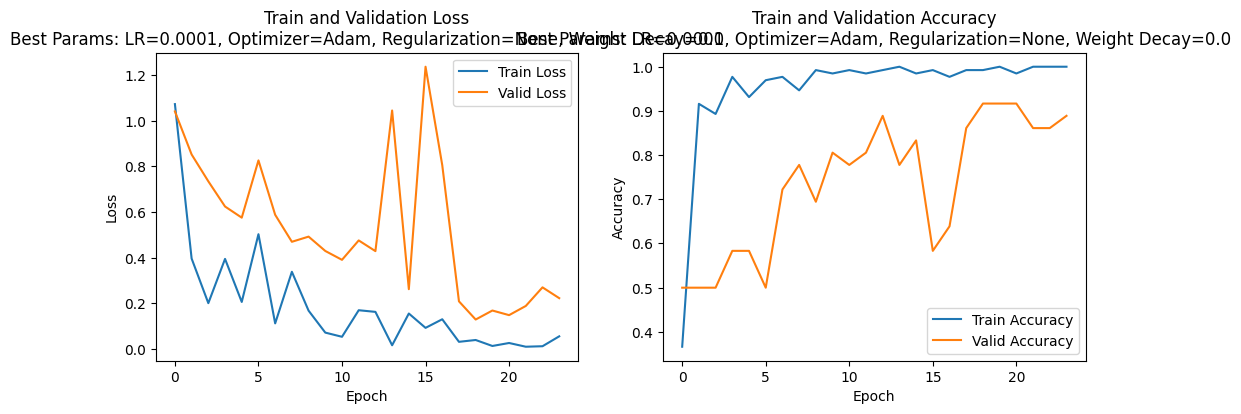

In [15]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2885, 0.3756, 0.3216], std=[0.3790, 0.2832, 0.2951])
])

class CustomCOCODataset(Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.image_dir = image_dir
        self.transform = transform
        self.img_ids = [img_id for img_id in self.img_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        label = annotations[0]['category_id']
        return image, label

# Define Resnet-18
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Block
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


train_dataset = CustomCOCODataset(os.path.join(data_dir, 'train'), os.path.join(data_dir, 'train/_annotations.coco.json'), transform=transform)
valid_dataset = CustomCOCODataset(os.path.join(data_dir, 'valid'), os.path.join(data_dir, 'valid/_annotations.coco.json'), transform=transform)

fixed_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=fixed_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=fixed_batch_size, shuffle=False)

# Grid Search
param_grid = {
    "learning_rate": [0.01, 0.001, 0.0001],
    "optimizer": ["Adam", "SGD", "RMSprop"],
    "regularization": ["L2", "L1", "None"],
    "weight_decay": [0.0, 0.0001, 0.001]
}

class ResNet18WithDropout(ResNet18):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(ResNet18WithDropout, self).__init__(num_classes)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout Layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        return x


# Train
def train_and_evaluate_model(learning_rate, optimizer_name, regularization, weight_decay=0.0):
    early_stop_patience = 5
    best_valid_loss = float('inf')
    early_stop_counter = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Dropout
    if regularization == "Dropout":
        model = ResNet18WithDropout(num_classes=3).to(device)
    else:
        model = ResNet18(num_classes=3).to(device)
        
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=(weight_decay if regularization == "L2" else 0))
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=(weight_decay if regularization == "L2" else 0))
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=(weight_decay if regularization == "L2" else 0))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    best_model_weights = copy.deepcopy(model.state_dict())

    num_epochs = 50
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # L1
            l1_regularization = 0
            if regularization == "L1":
                for param in model.parameters():
                    l1_regularization += torch.sum(torch.abs(param))
                loss = criterion(outputs, labels) + 0.001 * l1_regularization
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        valid_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = correct / total
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Valid Acc: {valid_accuracy:.4f}")

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered")
                break
    
    return best_valid_loss, best_model_weights, train_losses, valid_losses, train_accuracies, valid_accuracies


# Grid Search with regularization method comparison
best_params = None
best_score = float('inf')
best_model_path = 'best_model.pth'

best_train_losses, best_valid_losses = [], []
best_train_accuracies, best_valid_accuracies = [], []

for lr in param_grid['learning_rate']:
    for optimizer_name in param_grid['optimizer']:
        for reg_method in param_grid['regularization']:
            for weight_decay in (param_grid['weight_decay'] if reg_method == "L2" else [0.0]):  # L2
                print(f"Training with lr={lr}, optimizer={optimizer_name}, regularization={reg_method}, weight_decay={weight_decay}")
                valid_loss, best_model_weights, train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_evaluate_model(lr, optimizer_name, reg_method, weight_decay)
                
                # Update the best model
                if valid_loss < best_score:
                    best_score = valid_loss
                    best_params = {'learning_rate': lr, 'optimizer': optimizer_name, 'regularization': reg_method, 'weight_decay': weight_decay}
                    torch.save(best_model_weights, best_model_path)
                    best_train_losses = train_losses
                    best_valid_losses = valid_losses
                    best_train_accuracies = train_accuracies
                    best_valid_accuracies = valid_accuracies

print(f"Best HyperParameters={best_params['learning_rate']}, optimizer={best_params['optimizer']}, method={best_params['regularization']}, weight_decay={best_params['weight_decay']}")
print(f"Best Valid Loss: {best_score}")

# Plot Curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Train and Validation Loss\nBest Params: LR={best_params['learning_rate']}, Optimizer={best_params['optimizer']}, Regularization={best_params['regularization']}, Weight Decay={best_params['weight_decay']}")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Train Accuracy')
plt.plot(best_valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Train and Validation Accuracy\nBest Params: LR={best_params['learning_rate']}, Optimizer={best_params['optimizer']}, Regularization={best_params['regularization']}, Weight Decay={best_params['weight_decay']}")
plt.legend()

plt.show()


### Test Results ###

In [16]:
import torch
from sklearn.metrics import f1_score  
from torch.utils.data import DataLoader


test_dataset = CustomCOCODataset(
    os.path.join(data_dir, 'test'), 
    os.path.join(data_dir, 'test/_annotations.coco.json'), 
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=fixed_batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=3).to(device)
model.load_state_dict(torch.load('best_model.pth'))  

def evaluate_on_test_set(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test F1 Score: {f1:.4f}")

evaluate_on_test_set(model)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Test F1 Score: 0.7143
